In [1]:
import math
import tqdm
import itertools
import copy
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons
# PyTorch
import torch
torch.manual_seed(42)

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

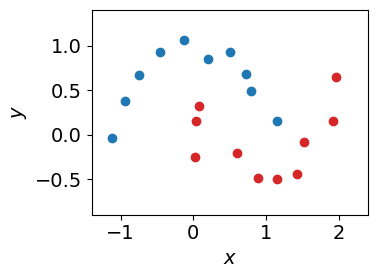

In [3]:
N = 20
X_numpy, y_numpy = make_moons(n_samples=N, noise=0.1, random_state=42)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
ax.scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
ax.set_xlim([-1.4, 2.4])
ax.set_ylim([-0.9, 1.4])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
def train_one_epoch(model, criterion, optimizer, X, y, num_samples=1):
    
    model.train()
    optimizer.zero_grad()
        
    avg_metrics = {}
    for _ in range(num_samples):
        
        logits = model(X)
        logits = torch.nn.functional.normalize(logits, dim=1)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
        metrics['loss'].backward()
        
        for key, value in metrics.items():
            avg_metrics.setdefault(key, 0.0)
            avg_metrics[key] += (1/num_samples) * value.item()
        
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.mul_(1/num_samples)

    optimizer.step()
    
    return avg_metrics

def evaluate(model, criterion, X, y):
    
    model.eval()
            
    with torch.no_grad():
        logits = model(X)
        logits = torch.nn.functional.normalize(logits, dim=1)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
        
    return metrics

In [5]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=1024),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1024, out_features=2),
)
encoder.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
encoder.temperature_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(0.5))))
utils.add_variational_layers(encoder, encoder.sigma_param)
encoder.use_posterior = types.MethodType(utils.use_posterior, encoder)
init_state_dict = copy.deepcopy(encoder.state_dict())

criterion = losses.KappaELBoLoss(1.0, encoder.sigma_param, criterion=losses.SINCERELoss(encoder.temperature_param))

best_state_dict = None
best_metric = np.inf

columns = ['epoch', 'lr', 'train_loss']
temp_df = pd.DataFrame(columns=columns)

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    encoder.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=0.0)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(encoder, criterion, optimizer, X, y.view(-1).long(), 5)
        temp_df.loc[len(temp_df)] = [epoch, lr, train_metrics['loss']]

    if train_metrics['loss'] < best_metric:
        best_state_dict = copy.deepcopy(encoder.state_dict())
        best_metric = train_metrics['loss']
        
encoder.load_state_dict(best_state_dict)
encoder.eval()

with torch.no_grad():    
    elbo_embeddings = encoder(X)
    elbo_embeddings = torch.nn.functional.normalize(elbo_embeddings, dim=1)
    torch.save(elbo_embeddings, 'classification_elbo_embeddings.pt')

100%|██████████| 10000/10000 [02:36<00:00, 63.83it/s]


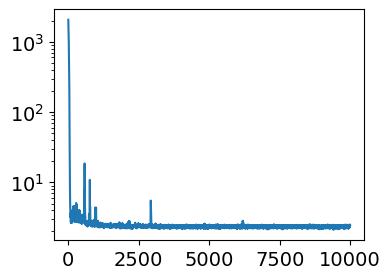

In [6]:
lr = 0.1

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(temp_df[temp_df.lr==lr].epoch.values, temp_df[temp_df.lr==lr].train_loss.values)
ax.set_yscale('log')

plt.show()

In [8]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=1024),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1024, out_features=2),
)
encoder.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
encoder.temperature_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(0.5))))
utils.add_variational_layers(encoder, encoder.sigma_param)
encoder.use_posterior = types.MethodType(utils.use_posterior, encoder)
init_state_dict = copy.deepcopy(encoder.state_dict())

criterion = losses.KappaELBoLoss(len(utils.flatten_params(encoder))/len(X), encoder.sigma_param, criterion=losses.SINCERELoss(encoder.temperature_param))

best_state_dict = None
best_metric = np.inf

columns = ['epoch', 'lr', 'train_loss']
temp_df = pd.DataFrame(columns=columns)

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    encoder.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=0.0)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(encoder, criterion, optimizer, X, y.view(-1).long(), 5)
        temp_df.loc[len(temp_df)] = [epoch, lr, train_metrics['loss']]

    if train_metrics['loss'] < best_metric:
        best_state_dict = copy.deepcopy(encoder.state_dict())
        best_metric = train_metrics['loss']
        
encoder.load_state_dict(best_state_dict)
encoder.eval()

with torch.no_grad():    
    de_elbo_embeddings = encoder(X)
    de_elbo_embeddings = torch.nn.functional.normalize(de_elbo_embeddings, dim=1)
    torch.save(de_elbo_embeddings, 'classification_de_elbo_embeddings.pt')

100%|██████████| 10000/10000 [02:34<00:00, 64.68it/s]


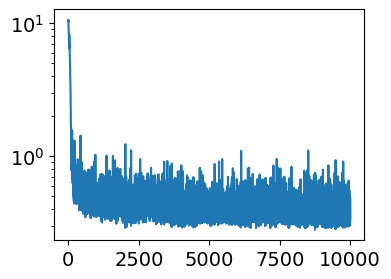

In [9]:
lr = 0.1

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(temp_df[temp_df.lr==lr].epoch.values, temp_df[temp_df.lr==lr].train_loss.values)
ax.set_yscale('log')

plt.show()

In [10]:
elbo_embeddings = torch.load('classification_elbo_embeddings.pt', weights_only=False)
de_elbo_embeddings = torch.load('classification_de_elbo_embeddings.pt', weights_only=False)

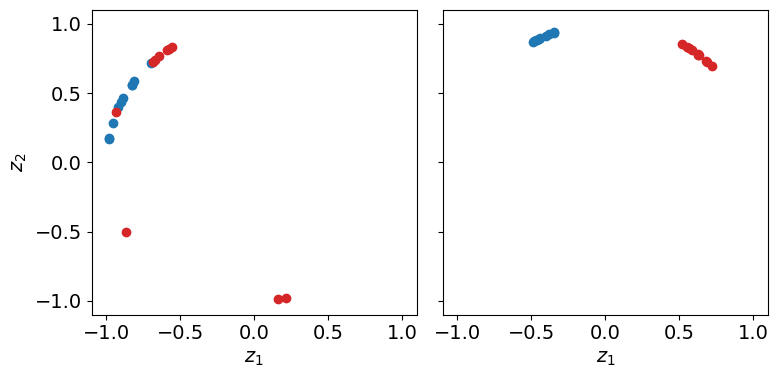

In [12]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 4*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(elbo_embeddings[:,0][y_numpy==0], elbo_embeddings[:,1][y_numpy==0], color='#1F77B4')
axs[0].scatter(elbo_embeddings[:,0][y_numpy==1], elbo_embeddings[:,1][y_numpy==1], color='#D62728')
axs[0].set_xlim([-1.1, 1.1])
axs[0].set_ylim([-1.1, 1.1])
axs[0].set_xlabel(r'$z_1$')
axs[0].set_ylabel(r'$z_2$')

axs[1].scatter(de_elbo_embeddings[:,0][y_numpy==0], de_elbo_embeddings[:,1][y_numpy==0], color='#1F77B4')
axs[1].scatter(de_elbo_embeddings[:,0][y_numpy==1], de_elbo_embeddings[:,1][y_numpy==1], color='#D62728')
axs[1].set_xlim([-1.1, 1.1])
axs[1].set_ylim([-1.1, 1.1])
axs[1].set_xlabel(r'$z_1$')

fig.tight_layout()
plt.show()